<a href="https://colab.research.google.com/github/ArpitKadam/Attention-Is-All-You-Code/blob/main/FineTuning-101/CHP_02_Instruction_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INSTRUCTION FINE-TUNING**

### **Preparing Dataset**

In [2]:
import os
import json
import urllib
import ssl

def download_and_load_data(file_path, url):
  ssl_content = ssl.create_default_context()
  ssl_content.check_hostname = False
  ssl_content.verify_mode = ssl.CERT_NONE

  if not os.path.exists(file_path):
    with urllib.request.urlopen(url, context=ssl_content) as data_file:
      text_data = data_file.read().decode("utf-8")

    with open(file_path, "w", encoding="utf-8") as file:
      file.write(text_data)

  with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

  return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_data(file_path, url)
print("Total Data:", len(data))

Total Data: 1100


In [3]:
data[0]

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}

In [4]:
type(data[0])

dict

In [5]:
data[1099]

{'instruction': "Change the sentence 'You should have called me.' into a question.",
 'input': '',
 'output': 'Should you have called me?'}

### **Converting instructions into Alpaca Format**

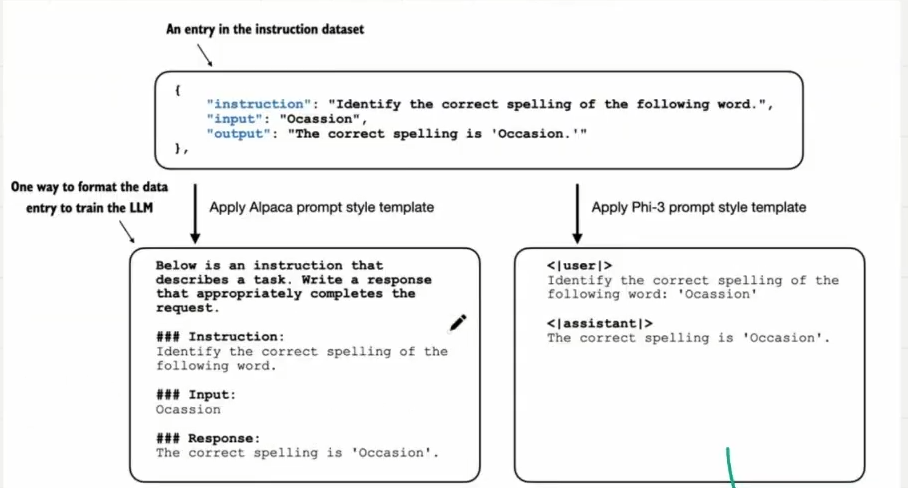

In [6]:
def format_input(entry):
  instruction_text = f"""Below is an istruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{entry['instruction']}
"""

  input_text = f"\n### Input: \n{entry['input']}" if entry['input'] else ""

  return instruction_text + input_text


In [7]:
example = format_input(data[135])
response = f"\n\n### Response: \n{data[135]['output']}"

print(example + response)

Below is an istruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the following sentence by adding one adverb.

### Input: 
The cat slept on the mat.

### Response: 
The cat peacefully slept on the mat.


In [8]:
from IPython.display import Markdown

Markdown(example + response)

Below is an istruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the following sentence by adding one adverb.

### Input: 
The cat slept on the mat.

### Response: 
The cat peacefully slept on the mat.

### **Organizing data into Training Batches**

In [9]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.33, random_state=42)

print("Train data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))

Train data size: 935
Validation data size: 110
Test data size: 55


In [10]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data

    self.encoded_texts = []
    for entry in self.data:
      inst_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = inst_plus_input + response_text

      self.encoded_texts.append(tokenizer.encode(full_text))

  def __getitem__(self, index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.encoded_texts)

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={'<|endoftext|>'}))

[50256]


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
def custom_collate_draft_1(batch, device, pad_token_id=50256):

  ## Find the longest sequence in the batch and increase the max_length +1,
  ## this adds one extra padding token below

  batch_max_length = max(len(item) + 1 for item in batch)

  inputs_list, targets_list = [], []

  for item in  batch:
    new_item = item.copy()
    new_item += [pad_token_id]
    padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

    # Via padded[:-1], we remove the extra padded token
    # that has been added via the +1 setting in batch_max_length
    # (the extra padding token will be relevant in later codes)
    inputs = torch.tensor(padded[:-1])
    targets = torch.tensor(padded[1:])
    inputs_list.append(inputs)
    targets_list.append(targets)

  inputs_tensor = torch.stack(inputs_list).to(device)
  targets_tensor = torch.stack(targets_list).to(device)
  return inputs_tensor, targets_tensor

In [14]:
input1 = [0, 1, 2, 4, 5, 6, 4, 5]
input2 = [7, 8, 9, 1, 4, 5]
input3 = [10,11,12]

batch = (
    input1,
    input2,
    input3
    )

inputs, targets = custom_collate_draft_1(batch, device)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     4,     5,     6,     4,     5],
        [    7,     8,     9,     1,     4,     5, 50256, 50256],
        [   10,    11,    12, 50256, 50256, 50256, 50256, 50256]],
       device='cuda:0')
tensor([[    1,     2,     4,     5,     6,     4,     5, 50256],
        [    8,     9,     1,     4,     5, 50256, 50256, 50256],
        [   11,    12, 50256, 50256, 50256, 50256, 50256, 50256]],
       device='cuda:0')


In [15]:
def custom_collate_fn(batch, device, pad_token_id=50256, ignore_index=-100, allowed_max_length=None):

  batch_max_length = max(len(item) + 1 for item in batch)

  inputs_list, targets_list = [], []

  for item in  batch:
    new_item = item.copy()
    new_item += [pad_token_id]
    padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

    inputs = torch.tensor(padded[:-1])
    targets = torch.tensor(padded[1:])

    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze()
    if indices.numel() > 1:
      targets[indices[1:]] = ignore_index

    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_list.append(inputs)
    targets_list.append(targets)

  inputs_tensor = torch.stack(inputs_list).to(device)
  targets_tensor = torch.stack(targets_list).to(device)

  return inputs_tensor, targets_tensor

In [16]:
input1 = [0, 1, 2, 4, 5, 6, 4, 5]
input2 = [7, 8, 9, 1, 4, 5]
input3 = [10,11,12]

batch = (
    input1,
    input2,
    input3
    )

inputs, targets = custom_collate_fn(batch, device)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     4,     5,     6,     4,     5],
        [    7,     8,     9,     1,     4,     5, 50256, 50256],
        [   10,    11,    12, 50256, 50256, 50256, 50256, 50256]],
       device='cuda:0')
tensor([[    1,     2,     4,     5,     6,     4,     5, 50256],
        [    8,     9,     1,     4,     5, 50256,  -100,  -100],
        [   11,    12, 50256,  -100,  -100,  -100,  -100,  -100]],
       device='cuda:0')


So, what's so special about -100 that it's ignored by the cross entropy loss? The default
setting of the cross entropy function in PyTorch is cross_entropy(...,
ignore_index=-100).

This means that it ignores targets labeled with -100.

### **Masking Target Token-IDs**

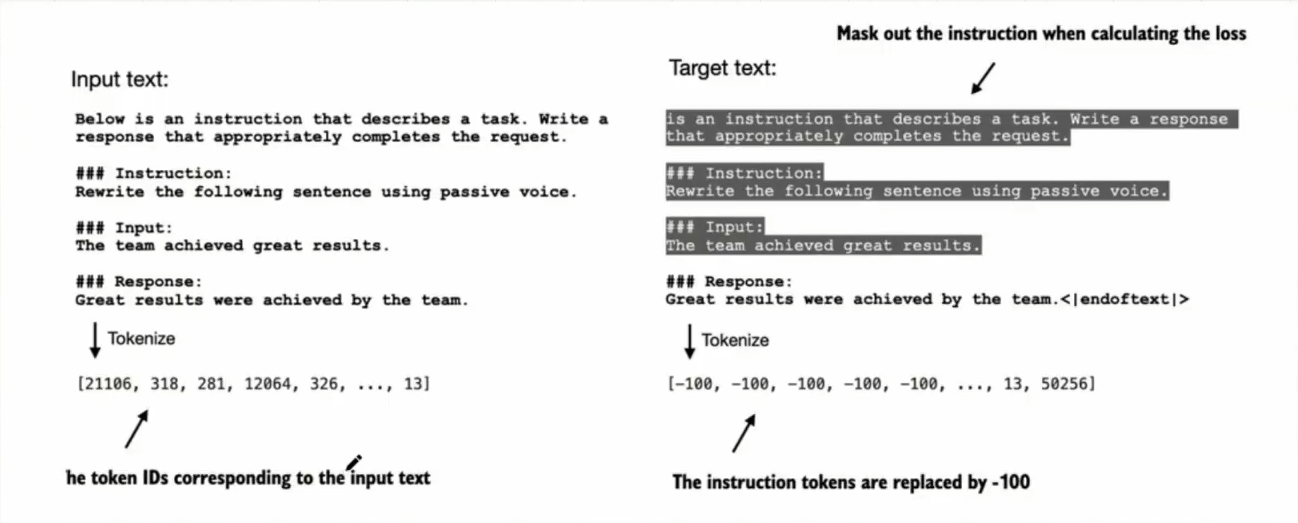

In addition to masking out padding tokens, it is also common to mask out the target
token IDs that correspond to the instruction

By masking out the target token IDs that correspond to the instruction, the LLM cross entropy loss is only computed for the generated response target
IDs.

By masking out the instruction tokens, the model is trained to focus on generating
accurate responses rather than additionally also memorizing instructions, which can help
with reducing overfitting.

Currently, researchers are divided on whether masking the instructions is universally beneficial during instruction finetuning.

For instance, a recent
paper titled "[Instruction Tuning With Loss Over Instructions](https://arxiv.org/abs/2405.14394)" demonstrated that not
masking the instructions benefits the LLM performance.

In this notebook, we do not apply masking.

### **Creating DataLoaders**

In [17]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [18]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 16
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

### **Initializing a model with pre-trained weights**

In [19]:
from gpt_download3 import download_and_load_gpt2
model_size = "355M"
MODEL = "gpt2-medium (355M)"

settings, params = download_and_load_gpt2(model_size, models_dir="gpt2-355M")

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.1,
    "qkv_bias": True
}

MODEL_CONFIG = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(MODEL_CONFIG[MODEL])

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 248kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.15MiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

In [20]:
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
    )

  def forward(self, x):
    return self.layers(x)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, drop_rate, num_heads, qkv_bias):
    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(drop_rate)
    self.register_buffer("simple_mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    batch, num_tokens, d_in = x.shape

    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = torch.matmul(queries, keys.transpose(2, 3))

    attn_scores.masked_fill_(
        self.simple_mask.bool()[:num_tokens, :num_tokens],
        -torch.inf
    )

    attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)

    attn_weights = self.dropout(attn_weights)

    context_vec = torch.matmul(attn_weights, values)

    context_vec = context_vec.transpose(1, 2)

    context_vec = context_vec.contiguous().view(batch, num_tokens, self.d_out)

    context_vec = self.out_proj(context_vec)

    return context_vec

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = cfg['emb_dim'],
        d_out = cfg['emb_dim'],
        context_length = cfg['context_length'],
        num_heads = cfg['n_heads'],
        qkv_bias = cfg['qkv_bias'],
        drop_rate = cfg['drop_rate']
      )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg['emb_dim'])
    self.norm2 = LayerNorm(cfg['emb_dim'])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    ## Connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    ## Conection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

class GPT_MODEL(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_out = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
    batch_size, seq_length = x.shape

    token_embeddings = self.token_emb(x)
    pos_embeddings = self.pos_emb(torch.arange(seq_length, device=x.device))

    x = token_embeddings + pos_embeddings
    x = self.drop_out(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):

    idx_crop = idx[:, -context_size:]

    with torch.no_grad():
      logits = model(idx_crop)

    logits = logits[:, -1, :]

    probas = torch.softmax(logits, dim=-1)

    idx_next = torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  token_list = token_ids.squeeze(0).tolist()
  decoded_text = tokenizer.decode(token_list)
  return decoded_text

def cal_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

def cal_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")

  elif num_batches is None:
    num_batches = len(data_loader)

  else:
    ## Reduce the number of batches to match the total number of batches in dataloader
    ## i.e if num_batches exceeds the number of the batches in data_loader
    num_batches = min(num_batches, len(data_loader))

  for batch_idx, (input_batch, target_batch) in enumerate(data_loader):
    if batch_idx < num_batches:
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break

  return total_loss / num_batches

In [21]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch: {left.shape} != {right.shape}")
  else:
    return torch.nn.Parameter(torch.tensor(right))

import numpy as np

def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
  gpt.token_emb.weight = assign(gpt.token_emb.weight, params["wte"])

  for b in range(len(params['blocks'])):
    q_w, k_w, v_w = np.split(
        (params['blocks'][b]['attn']['c_attn'])["w"], 3, axis=-1
    )
    gpt.trf_blocks[b].attn.W_query.weight = assign(gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
    gpt.trf_blocks[b].attn.W_key.weight = assign(gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
    gpt.trf_blocks[b].attn.W_value.weight = assign(gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

    q_b, k_b, v_b = np.split(
        (params['blocks'][b]['attn']['c_attn'])["b"], 3, axis=-1
    )
    gpt.trf_blocks[b].attn.W_query.bias = assign(gpt.trf_blocks[b].attn.W_query.bias, q_b)
    gpt.trf_blocks[b].attn.W_key.bias = assign(gpt.trf_blocks[b].attn.W_key.bias, k_b)
    gpt.trf_blocks[b].attn.W_value.bias = assign(gpt.trf_blocks[b].attn.W_value.bias, v_b)

    gpt.trf_blocks[b].attn.out_proj.weight = assign(gpt.trf_blocks[b].attn.out_proj.weight, params['blocks'][b]['attn']['c_proj']['w'].T)
    gpt.trf_blocks[b].attn.out_proj.bias = assign(gpt.trf_blocks[b].attn.out_proj.bias, params['blocks'][b]['attn']['c_proj']['b'])

    gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params['blocks'][b]['mlp']['c_fc']['w'].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params['blocks'][b]['mlp']['c_fc']['b'])

    gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params['blocks'][b]['mlp']['c_proj']['w'].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params['blocks'][b]['mlp']['c_proj']['b'])

    gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params['blocks'][b]['ln_1']['g'])
    gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params['blocks'][b]['ln_1']['b'])

    gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params['blocks'][b]['ln_2']['g'])
    gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params['blocks'][b]['ln_2']['b'])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params['b'])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [22]:
model = GPT_MODEL(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPT_MODEL(
  (token_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_out): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Lin

In [23]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an istruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provide a synonym for 'quick'.



In [24]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [25]:
token_ids = generate(
    model,
    text_to_token_ids(input_text, tokenizer),
    35,
    BASE_CONFIG['context_length'],
    50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print(generated_text)

Below is an istruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provide a synonym for 'quick'.
enegger rendering GroundTempfinalTweetntonbanks sanctions不 reduFsitionernel planesーティ pathologyluenceoungeIsraeli postersvy unattCritical spacingberries accounting Slate Indianahak ShotsXT reson Mohammadanders


In [26]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

enegger rendering GroundTempfinalTweetntonbanks sanctions不 reduFsitionernel planesーティ pathologyluenceoungeIsraeli postersvy unattCritical spacingberries accounting Slate Indianahak ShotsXT reson Mohammadanders


### **FineTuning the LLM**

In [27]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0

  if len(data_loader) == 0:
    return float("nan")

  elif num_batches is None:
    num_batches = len(data_loader)

  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break

  return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()

  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)

  model.train()

  return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model, encoded, 50, context_size)
  decoded = token_ids_to_text(token_ids, tokenizer)
  print(decoded.replace("\n", " "))
  model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):

  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()

      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Epoch: {epoch+1}, Step: {global_step:06d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    generate_and_print_sample(model, tokenizer, device, start_context)

  return train_losses, val_losses, track_tokens_seen

In [28]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=16)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches=16)

print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Train Loss: 3.9530, Val Loss: 3.9381


In [29]:
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 3
train_losses, val_losses, track_tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq=100,
    eval_iter=50,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds")

Epoch: 1, Step: 000000, Train Loss: 2.5831, Val Loss: 2.5717
Below is an istruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Provide a synonym for 'quick'.  ### Input:  quick  ### Response: A synonym for 'quick' is 'quick'.<|endoftext|>The following is an istruction that describes a task. Write a response that appropriately completes the request.  ### Instruction
Epoch: 2, Step: 000100, Train Loss: 0.4594, Val Loss: 0.5983
Below is an istruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Provide a synonym for 'quick'.  ### Input:  quick  ### Response: A synonym for 'quick' is 'quick as a whip'.<|endoftext|>The following is an istruction that describes a task. Write a response that appropriately completes the request. 
Below is an istruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Provide a synonym for 'quick'.  #

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(train_losses, val_losses, tokens_seen, epochs_seen):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

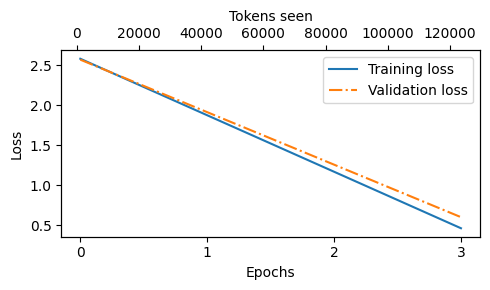

In [31]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(train_losses, val_losses, track_tokens_seen, epochs_tensor)

### **Evaluating the Fine-Tuned LLM**

In [44]:
torch.manual_seed(123)


for entry in test_data[7:9]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------\n\n")

Below is an istruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the interjection in the sentence.

### Input: 
Ouch, that hurt!

Correct response:
>> The interjection in the sentence is 'Ouch.'

Model response:
>> The interjection in the sentence is 'Ouch.'
-------------------------------------


Below is an istruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name an antonym for 'happiness.'


Correct response:
>> An antonym for 'happiness' is 'sadness.'

Model response:
>> An antonym for 'happiness' is 'sad.'
-------------------------------------




In [45]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model = model,
        idx = text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens = 256,
        context_size = BASE_CONFIG['context_length'],
        eos_id = 50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    test_data[i]['model_response'] = response_text

with open("/content/instruction-data-with-response.json", "w") as file:
  json.dump(test_data, file, indent=4)

100%|██████████| 55/55 [00:39<00:00,  1.40it/s]


In [46]:
file_name = "gpt-2-355M-sft.pth"
torch.save(model.state_dict(), file_name)

print(f"Model saved as {file_name}")

Model saved as gpt-2-355M-sft.pth


In [49]:
import psutil

def check_if_running(process_name):
  running = False

  for proc in psutil.process_iter(['name']):
    if process_name in proc.info['name']:
      running = True

  return running

ollama_running = check_if_running("ollama")

print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [58]:
!ollama run llama3.2:1b

>>> Send a message (/? for help)Hey!
... !
How's it going? What's on your mind today?

>>> Send a message (/? for help)/bye
... 


In [51]:
import urllib.request

def query_model(
    prompt,
    model="llama3.2:1b",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [54]:
result = query_model("What is Attention Mechanism?")
Markdown(result)

The attention mechanism, also known as the "attention" or "focus" mechanism, is a fundamental concept in deep learning and artificial intelligence. It's a way to selectively focus on certain parts of an input data, such as images, audio, or text, while ignoring others.

In traditional machine learning models, all parts of the input data are treated equally, regardless of their importance or relevance. This can lead to several issues:

1. **Overfitting**: The model becomes too specialized in recognizing specific patterns and ignores general trends.
2. **Underfitting**: The model fails to capture important features, resulting in poor performance on unseen data.

The attention mechanism addresses these problems by introducing a way to weigh the importance of different parts of the input data. It does this by computing a "score" or "weight" for each feature, which represents its relevance to the task at hand.

Here's a simplified example:

Suppose you're building a model that classifies images as either "cats" or "dogs." The attention mechanism would compute a score for each pixel in the image, indicating how likely it is to be a cat. This score would be used to weight the importance of different features, such as:

* The color palette (e.g., blue and green)
* Texture (e.g., fur texture)
* Shape (e.g., dog shape)

The model would then use these weighted scores to focus on the most relevant parts of the image, increasing its chances of correctly classifying it as a cat.

In more technical terms, the attention mechanism typically involves:

1. **Feature extraction**: Extracting relevant features from the input data.
2. **Weight calculation**: Computing weights for each feature based on their importance or relevance to the task.
3. **Attention computation**: Computing a weighted sum of the feature values, which represents the "attention" or "focus" mechanism.

The attention mechanism has many applications in areas like:

* Natural Language Processing (NLP): Attention is used to focus on specific parts of text, such as keywords or phrases.
* Computer Vision: Attention is used to focus on specific features, such as edges or textures.
* Speech Recognition: Attention is used to focus on specific acoustic features, such as voice patterns.

Overall, the attention mechanism is a powerful tool for selectively focusing on certain parts of an input data, enabling models to better capture complex relationships and make more accurate predictions.

In [66]:
for entry in test_data[3:7]:
    prompt = f"""
You are an impartial evaluator (LLM-as-a-judge).

Evaluate the MODEL RESPONSE against the CORRECT OUTPUT for the given TASK.

TASK:
{format_input(entry)}

CORRECT OUTPUT:
{entry['output']}

MODEL RESPONSE:
{entry['model_response']}

SCORING RULES:
- Score must be an integer between 0 and 100.
- 100 = perfectly correct and well-formatted.
- 0 = completely incorrect or irrelevant.
- If the final numerical answer is incorrect, the score MUST be <= 20.

IMPORTANT:
- Do NOT solve the task again.
- Do NOT correct the answer.
- ONLY evaluate the given model response.

OUTPUT FORMAT (STRICT JSON ONLY):
{{
  "score": <integer 0-100>,
  "justification": "<1–2 sentence explanation>"
}}
"""

    print("=" * 150)
    print("JUDGE PROMPT:")
    print(prompt.strip())

    result = query_model(prompt)

    print("\nJUDGE OUTPUT:")
    print(result)
    print("=" * 150)


JUDGE PROMPT:
You are an impartial evaluator (LLM-as-a-judge).

Evaluate the MODEL RESPONSE against the CORRECT OUTPUT for the given TASK.

TASK:
Below is an istruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify the following into vegetables, animals, and metals.

### Input: 
Broccoli, Iron, Elephant

CORRECT OUTPUT:
Vegetables: Broccoli
Metals: Iron
Animals: Elephant

MODEL RESPONSE:
Animals: Elephant
Plants: Broccoli
Minerals: Iron
Plants: Elephant

SCORING RULES:
- Score must be an integer between 0 and 100.
- 100 = perfectly correct and well-formatted.
- 0 = completely incorrect or irrelevant.
- If the final numerical answer is incorrect, the score MUST be <= 20.

IMPORTANT:
- Do NOT solve the task again.
- Do NOT correct the answer.
- ONLY evaluate the given model response.

OUTPUT FORMAT (STRICT JSON ONLY):
{
  "score": <integer 0-100>,
  "justification": "<1–2 sentence explanation>"
}

JUDGE OUTPUT:
{
  "score": 4